In [1]:
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')


from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from var_model import ClimateVAR
from sdice_model import SimplifiedDICE

In [2]:
# Instancia para limpiar y procesar los datos climáticos
climate_cleaner = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx')
climate_data = climate_cleaner.clean_and_prepare_data()

# Instancia para limpiar y procesar los datos climáticos
economic_cleaner = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv')
economic_data = economic_cleaner.clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
assets = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP'] 
benchmark = '^GSPC'  
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

combined_data = pd.merge(asset_prices, climate_data, on='Date').iloc[:-1]
all_data = pd.merge(combined_data, economic_data, on='Date')


[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
all_data.drop('Date', axis=1, inplace=True)

In [7]:
# Supongamos que ya tienes los datos cargados en all_data (tu matriz de variables endógenas)
var_model = ClimateVAR(all_data)

# Ajustar el modelo VAR con un máximo de 1 retardo
var_results = var_model.fit(maxlags=1)

# Visualizar el resumen de los parámetros ajustados
print("Parámetros ajustados del modelo VAR:")
print(var_results)

# Realizar predicción futura con el modelo VAR
# 'end' se puede ajustar según la longitud de tus datos. Aquí se supone que quieres predecir hasta el final de tus datos.
predict = var_model.predict(var_results, lags=5, end=100)  # Ajusta 'end' al número de observaciones deseado
print("Valores predichos:")
print(predict)



Valores predichos:
[[ 4.87728885e-02 -2.19733475e-01  1.37567426e+00 ...  2.19514625e+04
   3.96177303e+00  2.39511554e+02]
 [ 6.69324224e-02 -1.61532979e-01  1.39401994e+00 ...  2.17054622e+04
   3.69618586e+00  2.38882423e+02]
 [ 5.93908578e-02 -1.77956699e-01  1.33181377e+00 ...  2.16906659e+04
   3.78560975e+00  2.39065067e+02]
 ...
 [ 6.60307034e-02 -2.63862337e-01  1.47796980e+00 ...  3.06811438e+04
   8.73867523e+00  3.03078132e+02]
 [ 6.90962670e-02 -1.55776432e-01  1.24864976e+00 ...  2.98229139e+04
   7.82588945e+00  3.03116439e+02]
 [ 6.33865311e-02 -2.82172266e-01  1.29357466e+00 ...  3.02552829e+04
   8.48105442e+00  3.04206070e+02]]


<Axes: title={'center': 'Asset Returns'}, xlabel='Date'>

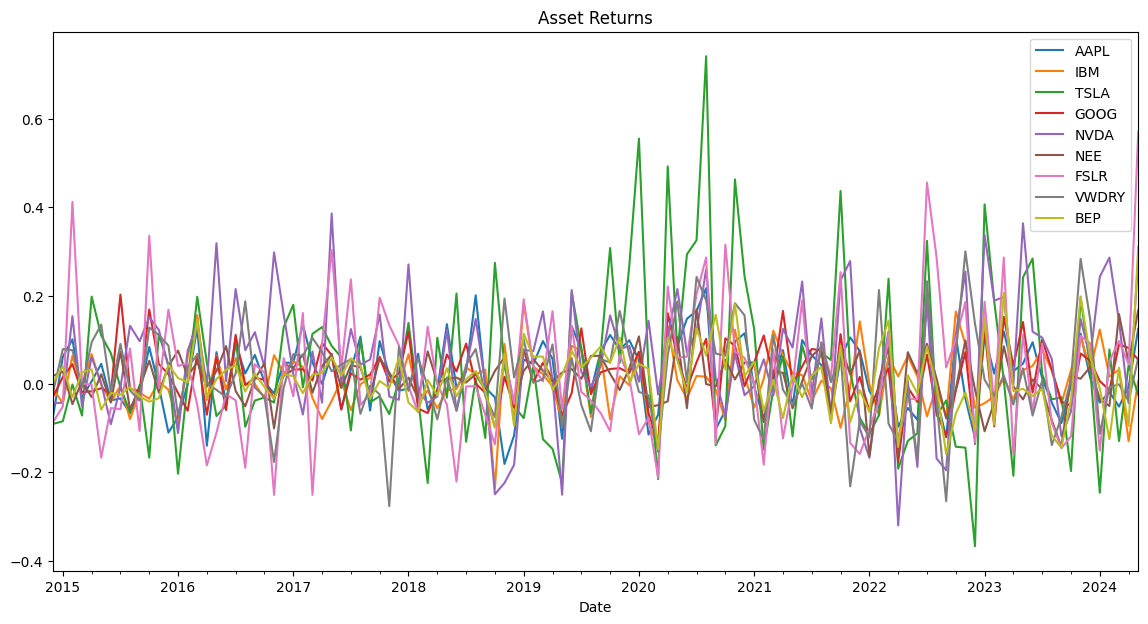

In [5]:
asset_prices.plot(x='Date', y=assets, figsize=(14, 7), title='Asset Returns')

In [6]:
# Assuming beta_calculator.calculate_betas() returns a DataFrame
betas = beta_calculator.calculate_betas()

# Plot the betas
betas.plot(kind='bar', figsize=(14, 7), title='Calculated Betas')

NameError: name 'beta_calculator' is not defined

In [ ]:
# Longitud de asset_prices
len_asset_prices = len(asset_prices)
print(f"Longitud de asset_prices: {len_asset_prices}")

# Longitud de climate_data
len_climate_data = len(climate_data)
print(f"Longitud de climate_data: {len_climate_data}")